In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Concatenate , Add, Dot, Activation, Lambda, BatchNormalization, LeakyReLU, Softmax, ReLU
from tensorflow.keras.models import Model

from tensorflow.image import flip_up_down, flip_left_right, rot90
from tensorflow.linalg import normalize

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import math

import matplotlib.pyplot as plt
import sys 
sys.path.append('..')
from layers.sorted_filters_with_shift import SortedConv2DWithShift

import datetime


In [2]:
from tensorflow.python.client import device_lib
#tf.disable_v2_behavior()

#print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

print(tf.__version__ )

Num GPUs Available:  1
2.9.1


In [3]:
input_net = Input((32, 32, 3))

y, map = SortedConv2DWithShift(filters=10 , activation=ReLU(), padding='SAME')(input_net)

y = layers.Flatten()(y)
y = layers.Dense(200, activation=ReLU())(y)
y = layers.BatchNormalization(axis=-1)(y)
output_net  = layers.Dense(100, activation=Softmax())(y)

model = Model(inputs = input_net, outputs = output_net)
model.summary()

TypeError: Exception encountered when calling layer "sorted_conv2d_with_shift" (type SortedConv2DWithShift).

in user code:

    File "c:\Users\AN46710\Desktop\ri_feature_cnn\Models\layers\sorted_filters_with_shift.py", line 183, in call  *
        out = tf.vectorized_map(self.n_roll, (x, -m), fallback_to_while_loop=False, warn=True)

    TypeError: vectorized_map() got an unexpected keyword argument 'warn'


Call arguments received by layer "sorted_conv2d_with_shift" (type SortedConv2DWithShift):
  • inputs=tf.Tensor(shape=(None, 32, 32, 3), dtype=float32)
  • training=None

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


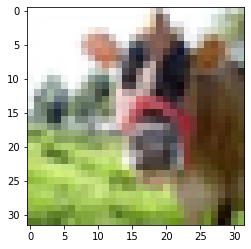

In [ ]:
num_classes = 100
input_shape = (32, 32, 3)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()



# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
#x_train = np.expand_dims(x_train, -1)
#x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

plt.imshow(x_train[0,:,:,:])



In [ ]:
model = Model(inputs = input_net, outputs = y)

initial_learning_rate =  0.01

lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate,
    alpha = 1e-6,
    m_mul=0.999,
    first_decay_steps = 20)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)

log_dir = "logs_shift_experiments/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
)


checkpoint_filepath = "/tmp/checkpoint"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

batch_size = 2
epochs = 1
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
out shape (2, 1024, 10)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
out shape (2, 1024, 10)


InvalidArgumentError: Graph execution error:

Detected at node 'model_1/sorted_conv2d_with_shift/loop_body/Slice/pfor/TensorListConcatV2' defined at (most recent call last):
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\asyncio\base_events.py", line 541, in run_forever
      self._run_once()
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\asyncio\base_events.py", line 1786, in _run_once
      handle._run()
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\asyncio\events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\IPython\core\interactiveshell.py", line 2915, in run_cell
      raw_cell, store_history, silent, shell_futures)
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\IPython\core\interactiveshell.py", line 3186, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\AN46710\AppData\Local\Temp\ipykernel_13824\1520246566.py", line 36, in <module>
      model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\keras\engine\training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\keras\engine\functional.py", line 459, in call
      inputs, training=training, mask=mask)
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\AN46710\Desktop\ri_feature_cnn\Models\layers\sorted_filters_with_shift.py", line 183, in call
      x = tf.vectorized_map(self.n_roll, (x, -m), fallback_to_while_loop=False, warn=True)
Node: 'model_1/sorted_conv2d_with_shift/loop_body/Slice/pfor/TensorListConcatV2'
PartialTensorShape: Incompatible shapes during merge: [16,2] vs. [16,4]
	 [[{{node model_1/sorted_conv2d_with_shift/loop_body/Slice/pfor/TensorListConcatV2}}]] [Op:__inference_train_function_102365]

In [ ]:
%tensorboard --logdir logs_shift_experiments/fit

UsageError: Line magic function `%tensorboard` not found.


In [ ]:
@tf.function
def roll(arg):
    x, map = arg
    shifted = tf.TensorArray(tf.float32, size=map.shape[-1], dynamic_size=False)
    print('here', map.shape)
    print('here', x.shape)

    for i in range(map.shape[-1]):
        tmp = tf.roll(x[i], shift=map[i], axis=-1)
        shifted = shifted.write(i, tmp)  # shape is (n_atoms, n_timesteps, n_atoms, n_atoms)
    out = shifted.stack()
    print(out.shape)
    return out

@tf.function
def myRoll(arg):
    x, map = arg
    
    shifted = tf.zeros([0, 10]) #tf.TensorArray(tf.float32, size=40, dynamic_size=False)
    print('here', map.shape)
    print('input shape', x.shape)
    for i in range(64):
        k = map[i] % 10
        shifted = tf.concat([shifted, tf.concat([tf.slice(x, [i*16, 10-k], [16,k]), tf.slice(x, [i*16, 0], [16,10-k])], -1)], 0)

    print('out', shifted.shape)
    return shifted



patches=4


get_layer_output = K.function([model.input], model.layers[1].output)

n = 109

X = x_test[n]
print(X.shape)

out = np.array(get_layer_output(np.expand_dims(X, axis=0))[0])
#shifted = np.array(get_layer_output(np.expand_dims(X, axis=0))[1])
map = np.array(get_layer_output(np.expand_dims(X, axis=0))[1])
plt.figure(1)  
im = plt.imshow(out[:,0,0])   
plt.colorbar(im, ticks=range(8), orientation="horizontal")

plt.figure(2)  
im = plt.imshow(out[0, :, : , 0])  

plt.colorbar(im, ticks=range(8), orientation="horizontal")


plt.figure(3)  
im = plt.imshow(map[0], cmap='gray') 
plt.colorbar(im, ticks=range(8), orientation="horizontal")


max_channels = map
print('mc', max_channels.shape)
max_channels  = tf.cast(max_channels, tf.float32)
averages = tf.nn.avg_pool2d((tf.expand_dims(max_channels, axis=-1)), ksize=[4, 4] , strides=[4, 4], padding='SAME')
print('avg', averages.shape)

'''map = tf.repeat(averages, repeats = 4, axis=1)
map = tf.repeat(map, repeats = 4, axis=2)'''
#map  = tf.cast(map, tf.int32)
map  = tf.cast(averages, tf.int32)


out = tf.reshape(out, [-1, out.shape[1]*out.shape[2], out.shape[3] ])
map = tf.reshape(map, [-1, map.shape[1]*map.shape[2]])
print(out.shape)
print('map',map.shape)
'''print(tf.range(out.shape[1])[0])
shifted = tf.vectorized_map(roll, (out, -1*map))
print(shifted.shape)

shifted = tf.reshape(shifted, shape=([1, 32, 32, 10]))
print(out.shape)
'''

out1 = tf.vectorized_map(myRoll, (out,-map))
print('done')
out1 = tf.reshape(out1, [-1, 32, 32, 10 ])


plt.figure(4)  
im = plt.imshow(out1[:,0,0])  

plt.colorbar(im, ticks=range(8), orientation="horizontal")

plt.figure(5)  
im = plt.imshow(out1[0, :, : , 0])  

plt.colorbar(im, ticks=range(8), orientation="horizontal")

print(map[0] % 10)


(32, 32, 3)


InvalidArgumentError: Exception encountered when calling layer "sorted_conv2d_with_shift" (type SortedConv2DWithShift).

Input to reshape is a tensor with 64 values, but the requested shape requires a multiple of 1024 [Op:Reshape]

Call arguments received by layer "sorted_conv2d_with_shift" (type SortedConv2DWithShift):
  • inputs=tf.Tensor(shape=(1, 32, 32, 3), dtype=float32)
  • training=None

In [ ]:
0

In [ ]:
model.layers[1].gain

In [ ]:
model.layers[5].scale_a